In [1]:
# !pip install uproot
# !pip install awkward
# !pip install vector

In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(uproot.__version__)
print(ak.__version__)

4.0.7
1.2.2


### 1. File I/O

In [4]:
# Read tree and show branches
infile = "../data/W_enu_pu200.root:Delphes"  # tree name: Delphes
tree = uproot.open(infile)
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Event                | TClonesArray             | AsGroup(<TBranchElement 'Ev...
Event/Event.fUniq... | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.fBits    | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.Number   | int64_t[]                | AsJagged(AsDtype('>i8'))
Event/Event.ReadTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.ProcTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Proce... | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.MPI      | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.Weight   | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/E

In [5]:
# Show the number of events
print("Number of events: {0}".format(tree.num_entries))

# Save the cut-flow
cut0 = np.zeros(tree.num_entries)

Number of events: 1000


### 2. Branch to Array

In [6]:
# Check the Electron branch
tree['Electron'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Electron             | TClonesArray             | AsGroup(<TBranchElement 'ElectElectron.fUniqueID   | uint32_t[]               | AsJagged(AsDtype('>u4'))
Electron.fBits       | uint32_t[]               | AsJagged(AsDtype('>u4'))
Electron.PT          | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Eta         | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Phi         | float[]                  | AsJagged(AsDtype('>f4'))
Electron.T           | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Charge      | int32_t[]                | AsJagged(AsDtype('>i4'))
Electron.EhadOverEem | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Particle    | TRef*                    | AsJagged(AsStridedObjects(M...
Electron.Isolatio... | float[]                  | AsJagged(AsDtype('>f4'))
El

In [7]:
# Check the MET branch
tree['MissingET'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
MissingET            | TClonesArray             | AsGroup(<TBranchElement 'MissiMissingET.fUniqueID  | uint32_t[]               | AsJagged(AsDtype('>u4'))
MissingET.fBits      | uint32_t[]               | AsJagged(AsDtype('>u4'))
MissingET.MET        | float[]                  | AsJagged(AsDtype('>f4'))
MissingET.Eta        | float[]                  | AsJagged(AsDtype('>f4'))
MissingET.Phi        | float[]                  | AsJagged(AsDtype('>f4'))


In [8]:
# Branch to array

tree_arr = tree.arrays(filter_name=['Electron*','MissingET*'])
# You can add other particels (e.g. filter_name=['Jet*]')

In [9]:
# You can access the all physics variables
# But this looks ugly... 
tree_arr['Electron.PT']

<Array [[148, 46.1], [129], ... [222], [203]] type='1000 * var * float32'>

In [10]:
# Electron group ( for more convenient )
Electron = ak.zip({
	"PT"		: tree_arr["Electron.PT"],
	"Eta"		: tree_arr["Electron.Eta"],
	"Phi"		: tree_arr["Electron.Phi"],
	"T"			: tree_arr["Electron.T"],
	"Charge"	: tree_arr["Electron.Charge"]
})

In [11]:
# MET group
MET = ak.zip({
	"MET"		: tree_arr["MissingET.MET"],
	"Eta"		: tree_arr["MissingET.Eta"],
	"Phi"		: tree_arr["MissingET.Phi"],
})

In [12]:
# Now, you can access the physics variables in this way
print(Electron.PT)
print(MET.MET)

[[148, 46.1], [129], [], [211], [313], ... [205], [], [218, 15.4], [222], [203]]
[[235], [338], [354], [238], [281], [322, ... [322], [247], [149], [350], [237]]


### 3. Selection

3.1 Electron definition

In [13]:
# Minimum PT cut >= 10 GeV
Ele_PT_mask = Electron.PT >= 10

# Tracker coverage |eta| <= 2.5
Ele_Eta_mask = abs(Electron.Eta) <= 2.5

# Combine cut1 and cut2 using AND(&) operator
Electron_selection_mask = (Ele_PT_mask) & (Ele_Eta_mask)

3.2 Select event with one or more selected Electrons

In [14]:
# Event mask
Electron = Electron[Electron_selection_mask]
Electron_event_mask = (ak.num(Electron) >= 1)

# Apply event selection
Electron = Electron[Electron_event_mask]
MET = MET[Electron_event_mask]
# Photon = Photo[Electron_event_mask]
# Jet = Jet[Electron_event_mask]


# CutFlow
cut1 = np.ones(len(Electron))
print("Cut0: {0}, Cut1: {1}".format(len(cut0), len(cut1)))

Cut0: 1000, Cut1: 792


### 4. Construct Kinematic variabels ( High-level variables )

In [15]:
import vector

In [16]:
leading_Electron = Electron[:,0] # Highest PT 

In [17]:
Ele2vec = vector.obj(pt=leading_Electron.PT, phi=leading_Electron.Phi)
MET2vec = vector.obj(pt=MET.MET, phi=MET.Phi)

In [18]:
MT =np.sqrt( 2 * leading_Electron.PT * MET.MET * (1 - np.cos(abs(MET2vec.deltaphi(Ele2vec)))) )

### 5. Visualize

In [19]:
def draw(arr,title,start,end,bin): # Array, Name, x_min, x_max, bin-number
    plt.figure(figsize=(8,5)) # Figure size
    bins = np.linspace(start,end,bin) # divide start-end range with 'bin' number
    binwidth = (end - start) / bin # width of one bin
    
    # Draw histogram
    plt.hist(arr,bins=bins,alpha=0.7,label=title) # label is needed to draw legend 
    
    plt.xticks(fontsize=16) # xtick size
    plt.xlabel(title,fontsize=16) # X-label
    #plt.xlabel('$e_{PT}',fontsize=16) # X-label (If you want LateX format)
    
    plt.ylabel('Number of Events/(%d GeV)' % binwidth,fontsize=16) # Y-label
    #plt.ylabel('Number of Events',fontsize=16) # Y-label withou bin-width 
    plt.yticks(fontsize=16) # ytick size
    
    plt.grid(alpha=0.5) # grid
    plt.legend(prop={'size':15}) # show legend

    # svae figuew
    #outname_fig = title + ".png"
    #plt.savefig(outname_fig)

    plt.show() # show histogram

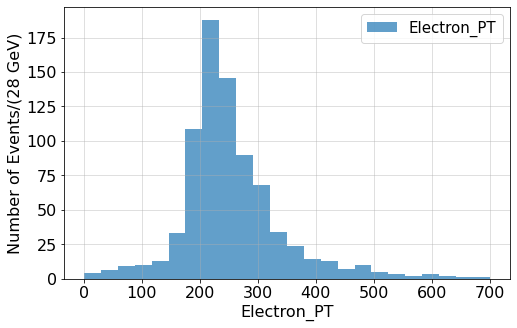

In [20]:
# Electron PT
draw(ak.flatten(Electron.PT),'Electron_PT',0,700,25)

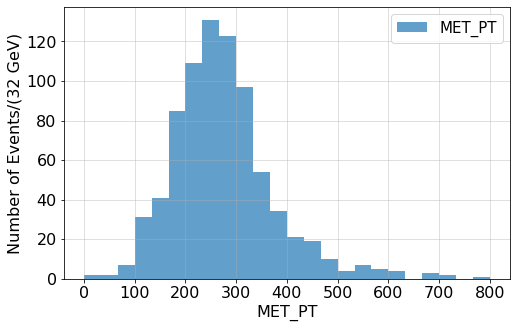

In [21]:
# MET PT
draw(ak.flatten(MET.MET),'MET_PT',0,800,25)

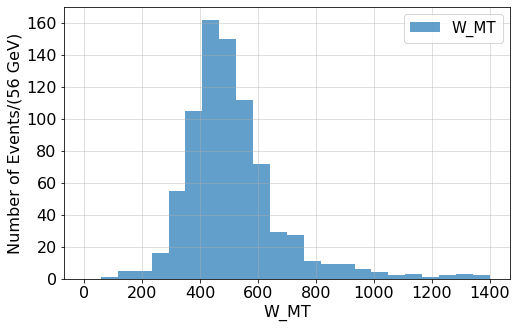

In [22]:
# MT
draw(ak.flatten(MT),'W_MT',0,1400,25)

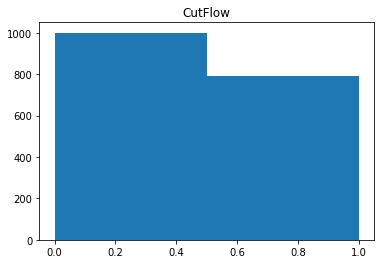

In [27]:
cutflow = np.concatenate([cut0,cut1])
plt.title('CutFlow')
plt.hist(cutflow,bins=2)
plt.show()
# 0 --> No cut 
# 1 --> Electron selection